In [1]:
%matplotlib inline

In [2]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import the statsmodels API
import statsmodels.api as sm

# Import the statsmodels formula API
import statsmodels.formula.api as smf

# Styling
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('phil.csv')

# Add the temperature data into the DataFrame
for i in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
    temp = pd.read_csv('%s.csv' % i)
    temp['year'] = temp['Date'].astype(str).str.slice(0,4).astype(int)
    temp[i] = temp['Value']
    df = df.merge(temp[['year', i]], on='year')
    #temp.head()
    
# Create an offset for the year, so 1898 is 0, 1899 is 1 and so on
df['year_offset'] = df['year'] - df['year'].min() + 1

# Take out the effect of global warming and the baseline temperature, so we're just left with an offset from 0.
# Negative numbers mean it's colder than average, positive means it's warmer.
for i in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
    cycle, trend = sm.tsa.filters.hpfilter(df['%s' % i], lamb = 100000)
    df['%s_offset' % i] = cycle
    
    # Assign a class. 1 = 6 more weeks of winter, 2 = early spring
    df['%s_class' % i] = 1
    df.loc[df['%s_offset' % i] > 0, '%s_class' % i] = 2
    
df.head()

,year,result,feb,mar,apr,febmar,marapr,febmarapr,year_offset,feb_offset,...,mar_offset,mar_class,apr_offset,apr_class,febmar_offset,febmar_class,marapr_offset,marapr_class,febmarapr_offset,febmarapr_class
0,1895,No Record,26.60,39.97,52.90,33.29,46.44,39.82,1,-4.618084,...,-0.957795,1,2.010331,2,-2.786048,1,0.528860,2,-1.191897,1
1,1896,No Record,35.04,38.03,52.34,36.54,45.19,41.80,2,3.752476,...,-2.907732,1,1.452128,2,0.424289,2,-0.725191,1,0.762230,2
2,1897,No Record,33.39,38.79,51.15,36.09,44.97,41.11,3,2.033083,...,-2.157660,1,0.263904,2,-0.065346,1,-0.949248,1,0.046369,2
3,1898,Saw Shadow,35.37,41.05,50.79,38.21,45.92,42.40,4,3.943744,...,0.092461,2,-0.094374,1,2.015070,2,-0.003308,1,1.310525,2
4,1899,No Record,25.50,37.63,50.61,31.57,44.12,37.91,5,-5.995551,...,-3.337310,1,-0.272745,1,-4.664438,1,-1.807360,1,-3.205299,1


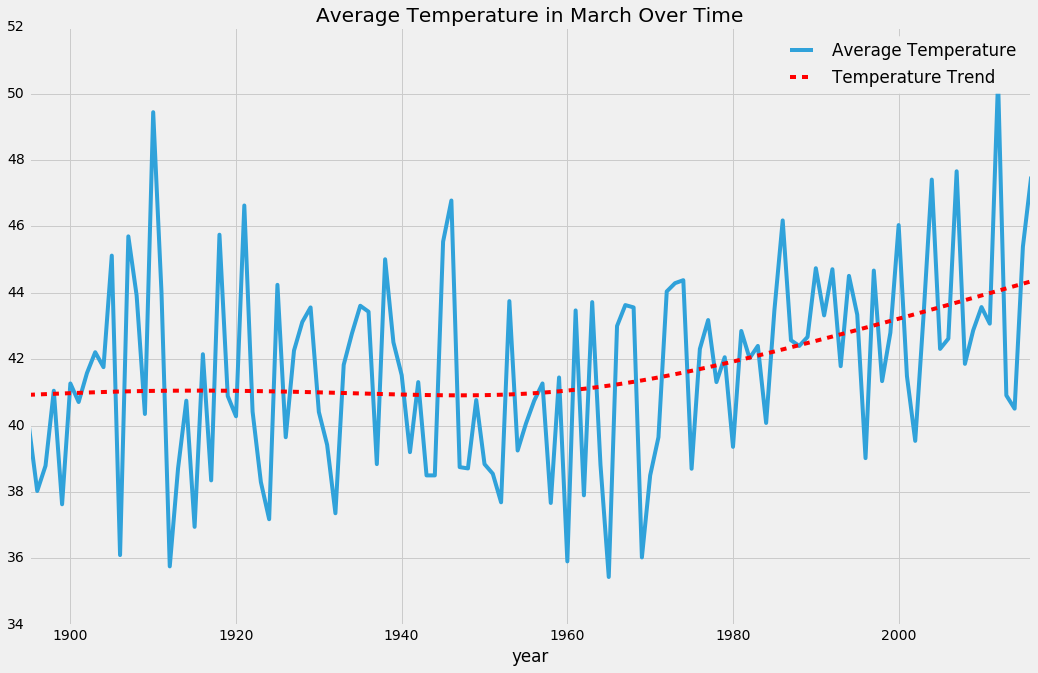

In [4]:
# Plot temperature trend
figure, ax = plt.subplots(figsize=(16,10))

df.plot('year', 'mar', title='Average Temperature in March Over Time', ax=ax, label='Average Temperature')

cycle, trend = sm.tsa.filters.hpfilter(df['mar'], lamb = 100000)
ax.plot(df['year'], trend, 'r--', label='Temperature Trend')
ax.legend()

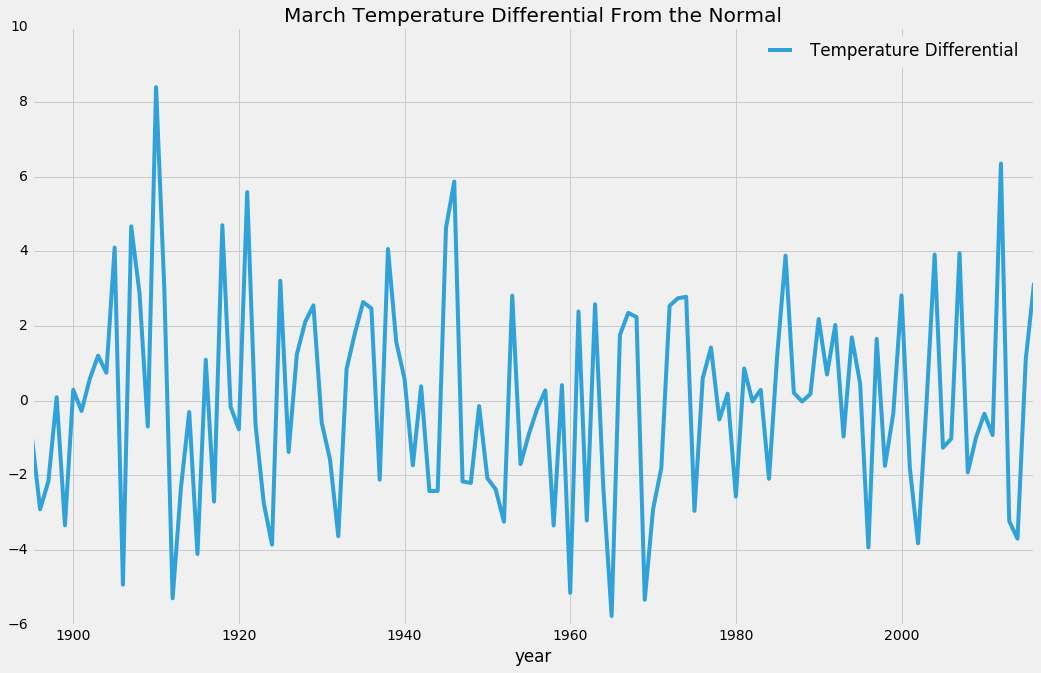

In [5]:
# Plot calculated offsets

figure, ax = plt.subplots(figsize=(16,10))

df.plot('year', 'mar_offset', title='March Temperature Differential From the Normal', ax=ax, label='Temperature Differential')

In [6]:
# We only care about years where we have a result.
df.loc[df['result'] == 'Saw Shadow', 'result'] = '6 more weeks of winter'
df.loc[df['result'] == 'No Shadow', 'result'] = 'Early spring'
df = df[(df['result'] == '6 more weeks of winter') | (df['result'] == 'Early spring')]

df.head()

,year,result,feb,mar,apr,febmar,marapr,febmarapr,year_offset,feb_offset,...,mar_offset,mar_class,apr_offset,apr_class,febmar_offset,febmar_class,marapr_offset,marapr_class,febmarapr_offset,febmarapr_class
3,1898,6 more weeks of winter,35.37,41.05,50.79,38.21,45.92,42.40,4,3.943744,...,0.092461,2,-0.094374,1,2.015070,2,-0.003308,1,1.310525,2
5,1900,6 more weeks of winter,30.76,41.27,51.60,36.02,46.44,41.21,6,-0.804854,...,0.293086,2,0.718757,2,-0.253866,1,0.508607,2,0.068887,2
6,1901,6 more weeks of winter,29.86,40.71,49.39,35.29,45.05,39.99,7,-1.774157,...,-0.276257,1,-1.489904,1,-1.023163,1,-0.885376,1,-1.176893,1
7,1902,Early spring,31.46,41.58,50.85,36.52,46.22,41.30,8,-0.243442,...,0.584751,2,-0.028767,1,0.167724,2,0.280714,2,0.107382,2
8,1903,6 more weeks of winter,28.42,42.21,50.22,35.32,46.22,40.28,9,-3.352674,...,1.206201,2,-0.657859,1,-1.071142,1,0.276912,2,-0.938252,1


In [7]:
# Run OLS regression to see if Phil's predictions are ever statistically significant:

for i in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
    # Run regression.  Note the call to `fit()` after the call to `ols`.
    mod = smf.ols(formula='%s_offset ~ C(result)' % i, data = df).fit()

    # Print the regression results if significant
    if mod.pvalues[1] <= .05:
        print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:             apr_offset   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6.328
Date:                Tue, 17 Jan 2017   Prob (F-statistic):             0.0133
Time:                        19:44:05   Log-Likelihood:                -227.43
No. Observations:                 116   AIC:                             458.9
Df Residuals:                     114   BIC:                             464.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept             

(1888, 2024)

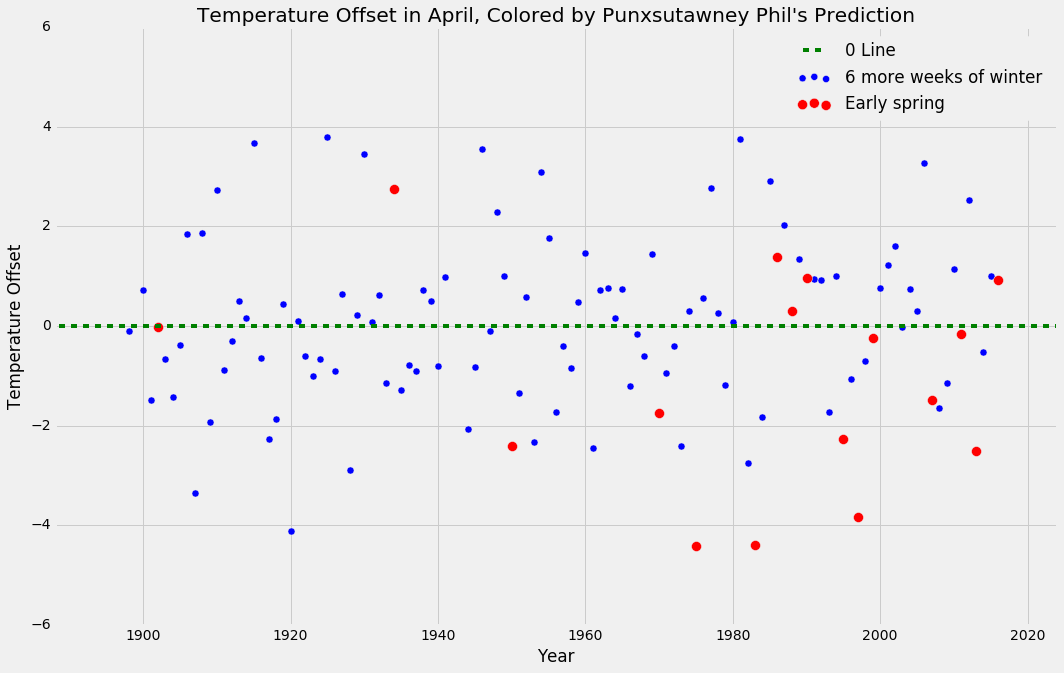

In [8]:
figure, ax = plt.subplots(figsize=(16,10))
ax.scatter(
    df['year'][df['result'] == '6 more weeks of winter'], 
    df['apr_offset'][df['result'] == '6 more weeks of winter'],
    label='6 more weeks of winter', s=50
)
ax.scatter(
    df['year'][df['result'] == 'Early spring'], 
    df['apr_offset'][df['result'] == 'Early spring'],
    label='Early spring', s=100, c='red'
)
ax.plot(ax.get_xlim(), [0,0], 'g--', label='0 Line')
ax.legend()
ax.set_title('Temperature Offset in April, Colored by Punxsutawney Phil\'s Prediction')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature Offset')
ax.set_xlim([1888,2024])

(1888, 2024)

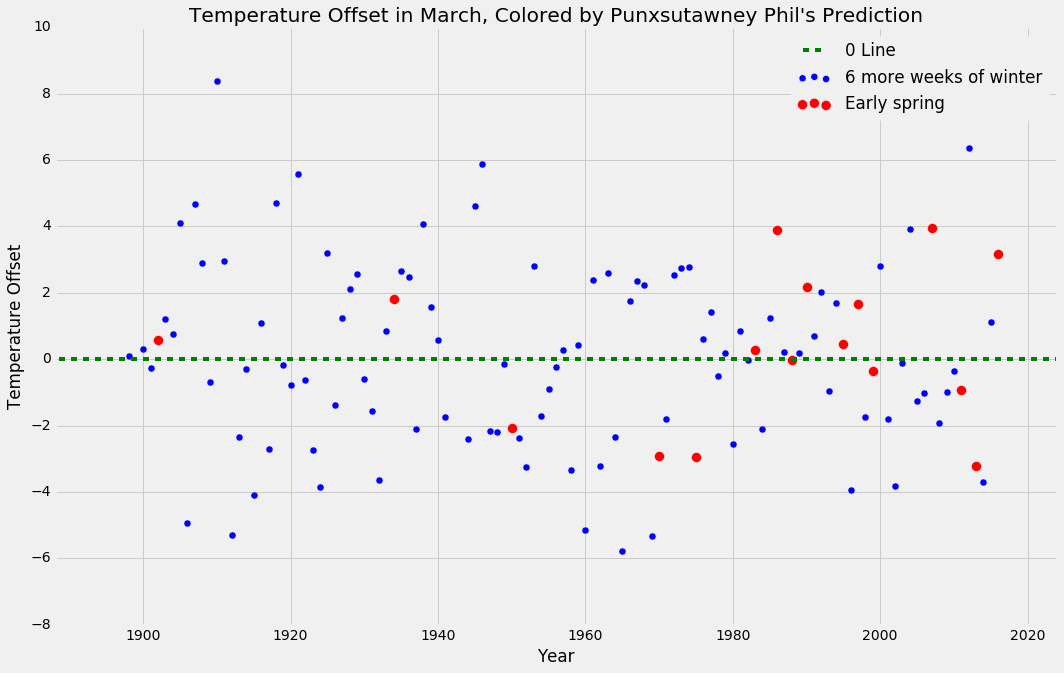

In [9]:
figure, ax = plt.subplots(figsize=(16,10))
ax.scatter(
    df['year'][df['result'] == '6 more weeks of winter'], 
    df['mar_offset'][df['result'] == '6 more weeks of winter'],
    label='6 more weeks of winter', s=50
)
ax.scatter(
    df['year'][df['result'] == 'Early spring'], 
    df['mar_offset'][df['result'] == 'Early spring'],
    label='Early spring', s=100, c='red'
)
ax.plot(ax.get_xlim(), [0,0], 'g--', label='0 Line')
ax.legend()
ax.set_title('Temperature Offset in March, Colored by Punxsutawney Phil\'s Prediction')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature Offset')
ax.set_xlim([1888,2024])

In [10]:
# Load the predictions for the rest of the groudhogs and clean the data

d = pd.read_csv('hogs.csv', sep='\t')
d['result'] = d['result'].str.extract('(.*)\[.*\]')
d['year'] = d['year'].astype(int)
d['name'] = d['name'].str.strip().str.replace(' ', '_')
d['name'] = d['name'].str.strip().str.replace('-', '_')
d = d[(d['result'] == '6 more weeks of winter') | (d['result'] == 'Early spring')]
names = d['name'].unique()
d.head()

c:\Users\Jeremy\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,year,result,name,location
0,2016,Early spring,Balzac_Billy,"Balzac, Alberta"
1,2016,6 more weeks of winter,Buckeye_Chuck,"Marion, Ohio"
2,2016,Early spring,Chattanooga_Chuck,"Chattanooga, Tennessee"
3,2016,6 more weeks of winter,Chesapeake_Chuck,"Newport News, Virginia"
4,2016,Early spring,Chuckles,"Manchester, Connecticut"


In [11]:
# Convert it into a DataFrame having dummy variables for each of the differnt groudhogs

all_hogs = pd.get_dummies(d, columns=['name'], prefix='', prefix_sep='')

# Indicate early spring predictions with a 2.  6 more weeks of winter will be a 1.  0 means no prediction for that year
all_hogs.loc[all_hogs['result'] == 'Early spring', names] *= 2
all_hogs = all_hogs.groupby('year', as_index=False).sum()
all_hogs = df.merge(all_hogs, on='year')

all_hogs

,year,result,feb,mar,apr,febmar,marapr,febmarapr,year_offset,feb_offset,...,Susquehanna_Sherman,T_Boy_the_Nutria,Tumbleweed,Uni,Western_Maryland_Murray,Wiarton_Willie,Winnipeg_Willow,Woodstock_Willie,Woody,Wynter_the_Groundhog
0,2008,6 more weeks of winter,34.70,41.86,50.40,38.28,46.13,42.32,114,-0.563150,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,2009,6 more weeks of winter,36.77,42.87,50.92,39.82,46.90,43.52,115,1.485535,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2010,6 more weeks of winter,31.80,43.57,53.24,37.69,48.41,42.87,116,-3.505715,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0
3,2011,Early spring,33.04,43.07,51.96,38.06,47.52,42.69,117,-2.286957,...,2.0,2.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0
4,2012,6 more weeks of winter,37.51,50.41,54.68,43.96,52.55,47.53,118,2.161783,...,2.0,2.0,0.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0
5,2013,Early spring,34.77,40.91,49.68,37.84,45.30,41.79,119,-0.599494,...,1.0,2.0,0.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0
6,2014,6 more weeks of winter,32.13,40.51,51.69,36.32,46.10,41.44,120,-3.260811,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
7,2015,6 more weeks of winter,32.99,45.39,53.24,39.19,49.32,43.87,121,-2.422184,...,2.0,2.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0
8,2016,Early spring,39.47,47.50,53.20,43.49,50.35,46.72,122,4.036402,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0


In [12]:
# Run OLS on all the differnt groudhogs individually

for hog in d.dropna()['name'].unique():
    for i in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
        mod = smf.ols(formula='%s_offset ~ C(%s)' % (i, hog), data = all_hogs[all_hogs[hog] > 0]).fit()

        # Print the regression results
        if len(mod.pvalues) > 1 and mod.pvalues[1] <= .05:
            print(mod.summary())

c:\Users\Jeremy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:             feb_offset   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     7.326
Date:                Tue, 17 Jan 2017   Prob (F-statistic):             0.0303
Time:                        19:44:06   Log-Likelihood:                -17.705
No. Observations:                   9   AIC:                             39.41
Df Residuals:                       7   BIC:                             39.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

c:\Users\Jeremy\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n))
c:\Users\Jeremy\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


                            OLS Regression Results                            
Dep. Variable:             mar_offset   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     12.39
Date:                Tue, 17 Jan 2017   Prob (F-statistic):             0.0244
Time:                        19:44:06   Log-Likelihood:                -11.862
No. Observations:                   6   AIC:                             27.72
Df Residuals:                       4   BIC:                             27.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

In [13]:
# Try a machine learning algorithm using all the predictions together.


from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

for m in ['feb', 'mar', 'apr', 'febmar', 'marapr', 'febmarapr']:
    results = []

    for i in range(1000):
        train_x, test_x, train_y, test_y = train_test_split(all_hogs[names], all_hogs['%s_class' % m], test_size=0.1)

        mod = SVC(kernel='poly', degree=3)
        mod.fit(train_x, train_y)
        results.append(mod.score(test_x, test_y))

    print(m)
    print('*'*20)
    print('prediction score:', np.array(results).mean())
    print('naive score:', max((all_hogs['%s_class' % m] == 1).sum() / 9, 1 - (all_hogs['%s_class' % m] == 1).sum() / 9))
    print('*'*20)

feb
********************
prediction score: 0.673
naive score: 0.666666666667
********************
mar
********************
prediction score: 0.769
naive score: 0.666666666667
********************
apr
********************
prediction score: 0.588
naive score: 0.555555555556
********************
febmar
********************
prediction score: 0.672
naive score: 0.666666666667
********************
marapr
********************
prediction score: 0.568
naive score: 0.555555555556
********************
febmarapr
********************
prediction score: 0.769
naive score: 0.777777777778
********************


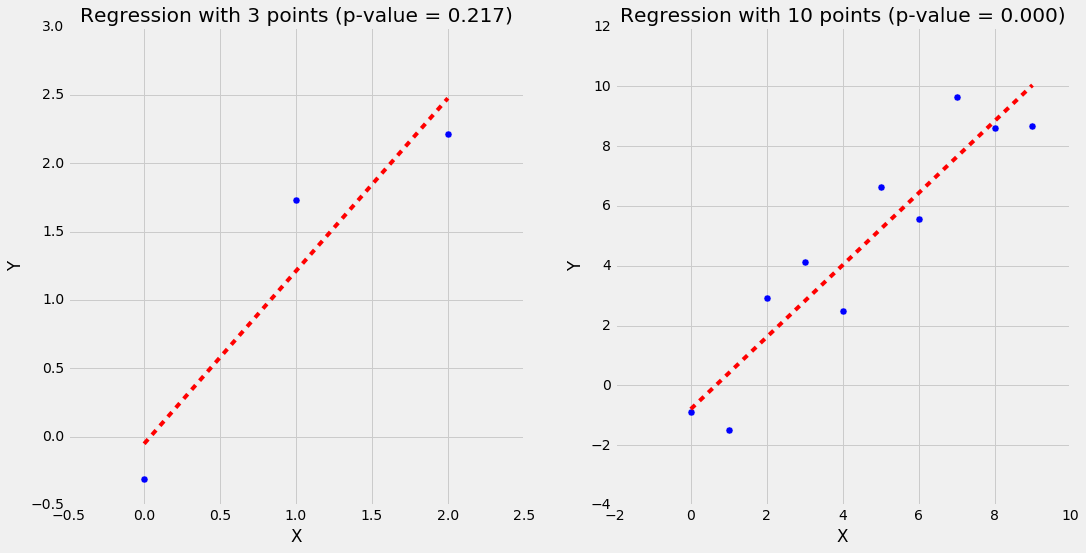

In [14]:
np.random.seed(6)
figure, ((ax0, ax1)) = plt.subplots(figsize=(16,8), nrows=1, ncols=2)

size = 3
x = np.arange(size)
noise = np.random.randn(size)
y = x + noise
d = {'x': x, 'y': y}
mod = smf.ols(formula='y ~ x', data = d).fit()

ax0.scatter(x, y, s=50)
r = mod.params[0] + mod.params[1] * x
ax0.plot(x,r, 'r--')
ax0.set_title('Regression with 3 points (p-value = %0.3f)' % mod.pvalues[1])
ax0.set_xlabel('X')
ax0.set_ylabel('Y')

size = 10
x = np.arange(size)
noise = np.random.randn(size)
y = x + noise
d = {'x': x, 'y': y}
mod = smf.ols(formula='y ~ x', data = d).fit()

ax1.scatter(x, y, s=50)
r = mod.params[0] + mod.params[1] * x
ax1.plot(x,r, 'r--')
ax1.set_title('Regression with 10 points (p-value = %0.3f)' % mod.pvalues[1])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')